In [1]:
import ipdb

# Data generation

## Generate data

In [2]:
# TODO:

## Save generated data

In [3]:
# TODO

# Visualization of the generated data

In [4]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
DATA_FILE_PATH_TO_LOAD = './dataset/data_3_g.json'
RAW_DATA = None

In [5]:
def visualize_data(occ_g, current_pos, goal_pos, next_pos, predicted_pos=None):
    occ_g = np.array(occ_g).reshape(10, 10)
    fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    occ_grid_size = occ_g.shape[0]
    tmp = occ_grid_size / 4.0 - 0.25
    s = (10.0 / occ_grid_size * 100 / 2) ** 2 + 500
    for i in range(occ_grid_size):
        for j in range(occ_grid_size):
            if occ_g[i,j] == 1:
                plt.scatter(j/2.0 - tmp, tmp - i/2.0, color="black", marker='s', s=s, alpha=1) # init

    ax.add_patch(patches.Rectangle((current_pos[0]-0.1, current_pos[1]-0.1), 0.2, 0.2, facecolor='y'))
    ax.add_patch(patches.Rectangle((goal_pos[0]-0.1, goal_pos[1]-0.1), 0.2, 0.2, facecolor='r'))
    ax.add_patch(patches.Rectangle((next_pos[0]-0.09, next_pos[1]-0.09), 0.18, 0.18, facecolor='g'))
    if predicted_pos is not None:
        ax.add_patch(patches.Rectangle((predicted_pos[0]-0.09, predicted_pos[1]-0.09), 0.18, 0.18, facecolor='b'))

                
    ax.set_title("Visualization")
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)

In [6]:
if RAW_DATA is None:
    with open(DATA_FILE_PATH_TO_LOAD) as _file:
        RAW_DATA = json.load(_file)

Randomly visualze a single data point.

- Black: obstacles
- Red: goal position
- Yellow: current position
- Green: the next position the robot should take

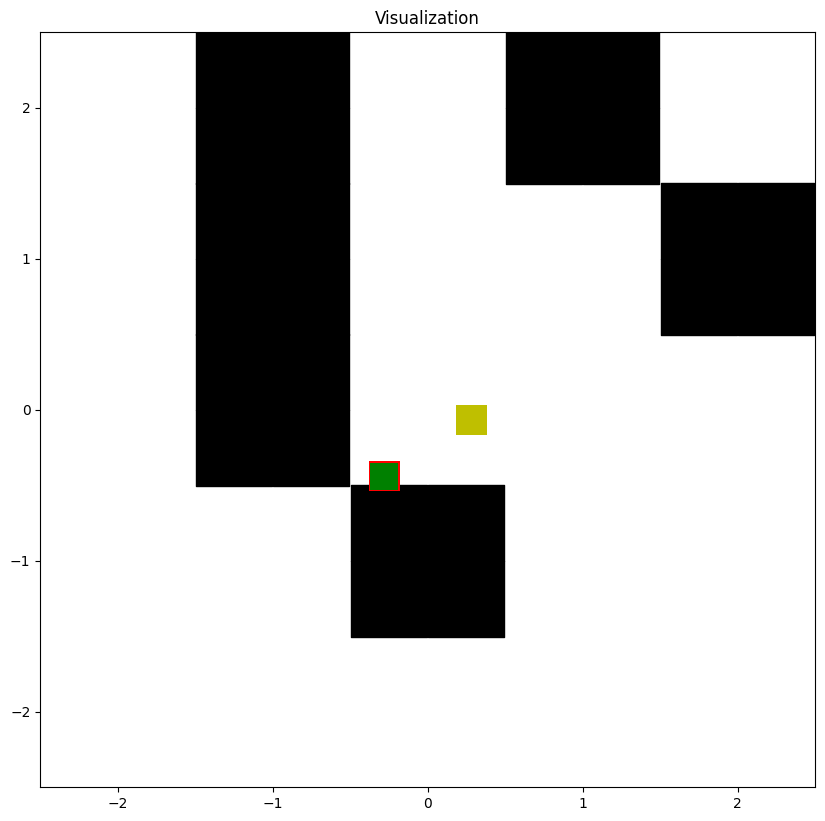

In [30]:
idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos, _, _ = RAW_DATA[idx]
visualize_data(occ_grid, current_pos, goal_pos, next_pos)

# Training

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions of networks and dataloaders

### MLP

In [9]:
class MLPDataset(Dataset):
    """A dataset class for the MLP.
    
    Input: A vector that concat current position, goal position and occupancy grid vector
    Output: Next position
    """
    def __init__(self, raw_data, transform=None, target_transform=None, device="cpu"):
        self.transform = transform
        self.target_transform = target_transform
        self.device = device
        self.dataset = raw_data
        print("dataset size = {}".format(len(self.dataset)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        start_pos, goal_pos, occ_grid, next_pos, non_connectable_nodes, dist = self.dataset[idx]

        dim = len(start_pos)
        start_pos = torch.Tensor(start_pos)
        goal_pos = torch.Tensor(goal_pos)
        occ_grid = torch.Tensor(occ_grid)
        next_pos = torch.Tensor(next_pos)

        input = torch.cat((start_pos, goal_pos, occ_grid), dim=0).to(self.device)
        next_pos = next_pos.to(self.device)

        return input, next_pos

    @classmethod
    def load_dataset_from_file(cls, file_path, device='cpu'):
        print("Loading data from {}".format(file_path))
        with open(file_path, 'r') as f:
            dataset = json.load(f)
        return cls(dataset, device=device)

In [10]:
class MLPModel(nn.Module):
    """A trivially simple MLP model."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        self.layers = nn.Sequential(
            nn.Linear(104, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, inputs):
        return self.layers(inputs)

## Training loop

Choose the network and dataloader classes

In [11]:
dataset_cls = MLPDataset
network_cls = MLPModel
criterion = torch.nn.MSELoss()
model_save_path = './models/mlp.pt'

Load the data

In [12]:
dataset = dataset_cls(RAW_DATA, device=DEVICE)

dataset size = 68957


Initialize the model

In [13]:
model = MLPModel().to(DEVICE)

Run the training loop

In [14]:
train_size = int(len(dataset) * 0.9)
batch_size = 64
learning_rate = 1e-4
num_epochs=10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
train_set = torch.utils.data.Subset(dataset, np.arange(train_size))
val_set = torch.utils.data.Subset(dataset, np.arange(train_size, len(dataset)))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(val_set, batch_size=1)

In [16]:
torch.autograd.set_detect_anomaly(True)

# Run the training loop
i = 0
for epoch in range(num_epochs):
    model.train()
    for data in train_dataloader:
        # Get batch of data
        inputs, labels = data
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        network_output = model.forward(inputs)
        # Compute loss
        loss = criterion(network_output, labels)
        # Ensure no funny numerics
        assert not torch.isnan(loss).any()
        # Perform backward pass
        loss.backward()
        # 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        # Perform optimization
        optimizer.step()
        # Print statistics
        current_loss = loss.item()
        if i % 100 == 0:
            print('-----------------Total loss after mini-batch %5d, epoch %d : %.3f' % (i, epoch, current_loss))
            current_loss = 0.0
        if i % 500 == 0:
            torch.save(model.state_dict(), model_save_path)
            print("saved session to ", model_save_path)

        i+=1

    if epoch % 5 == 0:
        # eval
        model.eval()
        total_loss = 0

        for data in eval_dataloader:
            # Get batch of data
            inputs, labels = data
            # Perform forward pass
            network_output = model.forward(inputs)
            # Compute loss
            loss = criterion(network_output, labels)
            total_loss += loss.detach().item()

        print("Evaluation----")
        print('-----------------Total loss after epoch %5d: %.3f' % (epoch, total_loss / len(eval_dataloader)))

-----------------Total loss after mini-batch     0, epoch 0 : 1.511
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch   100, epoch 0 : 0.264
-----------------Total loss after mini-batch   200, epoch 0 : 0.332
-----------------Total loss after mini-batch   300, epoch 0 : 0.259
-----------------Total loss after mini-batch   400, epoch 0 : 0.364
-----------------Total loss after mini-batch   500, epoch 0 : 0.418
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch   600, epoch 0 : 0.262
-----------------Total loss after mini-batch   700, epoch 0 : 0.210
-----------------Total loss after mini-batch   800, epoch 0 : 0.190
-----------------Total loss after mini-batch   900, epoch 0 : 0.245
Evaluation----
-----------------Total loss after epoch     0: 0.532
-----------------Total loss after mini-batch  1000, epoch 1 : 0.218
saved session to  ./models/mlp.pt
-----------------Total loss after mini-batch  1100, epoch 1 : 0.224
--------------

## Visualize the prediction

In [17]:
model = network_cls()
model.load_state_dict(torch.load(model_save_path))
model.to(DEVICE)
model.eval()

MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=104, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=2, bias=True)
  )
)

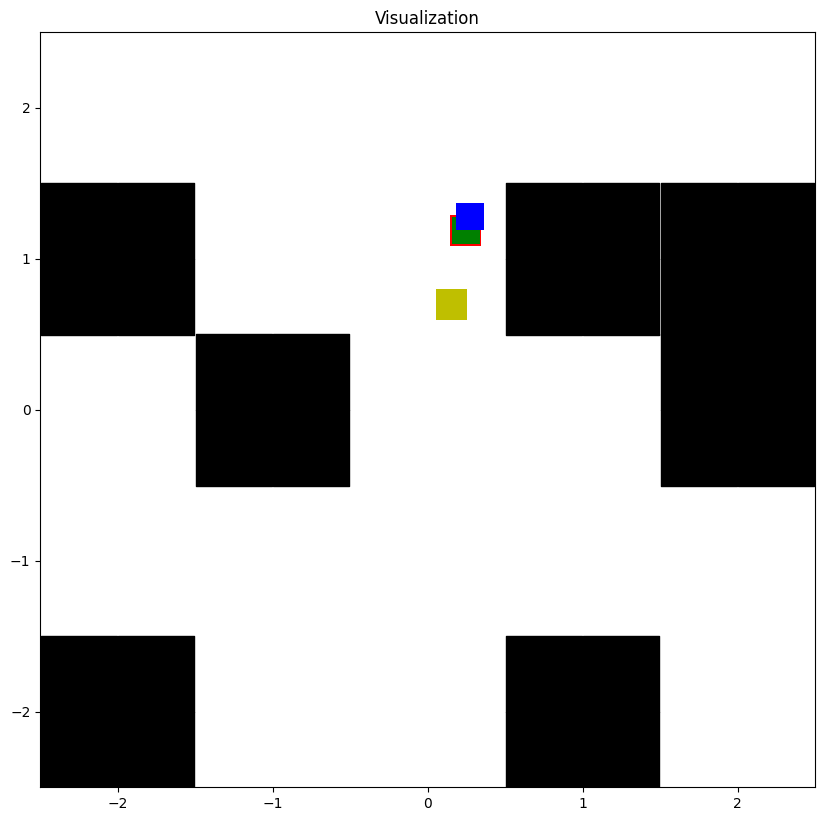

In [57]:
idx = np.random.randint(len(RAW_DATA))
current_pos, goal_pos, occ_grid, next_pos, _, _ = RAW_DATA[idx]
predicted_pos = model.forward(dataset[idx][0].view(1, -1)).detach().cpu().numpy().flatten()
visualize_data(occ_grid, current_pos, goal_pos, next_pos, predicted_pos=predicted_pos)

# Motion planning test